In [9]:
from simulation import Simulation
from time import time
from stats import Stats
import matplotlib.pyplot as plt
import numpy as np

def bootstrap_mse_convergence(simulation, stat_func=np.mean, max_bootstrap=1000, step=10):
    print("Running single simulation for bootstrap convergence analysis...")
    requests = simulation.run()
    stats = Stats(requests)
    data = stats.get_waiting_time()

    true_stat = stat_func(data)
    sample_sizes = range(step, max_bootstrap + 1, step)
    
    bootstrap_estimates = []
    mse_progression = []
    for i in range(max_bootstrap):
        bootstrap_estimates.append(stat_func(np.random.choice(data, size=len(data), replace=True)))
        
        if (i + 1) % step == 0 and i > 1:
            mse_progression.append(np.mean((np.array(bootstrap_estimates) - true_stat) ** 2))

    # Plot MSE vs number of bootstrap samples
    plt.figure(figsize=(8, 6))
    plt.plot(sample_sizes, mse_progression, marker='o', color='darkorange')
    plt.axhline(0.5, color='red', linestyle='--', label='Target MSE = 0.5')
    plt.title('Bootstrap MSE Convergence for Mean Waiting Time')
    plt.xlabel('Number of Bootstrap Samples')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(np.arange(0, 500, 25) + 1, 1.96*np.sqrt(mse_progression[-1]/(np.arange(0, 500, 25)+1)), marker='o', color='darkorange')
    plt.axhline(0.5, color='red', linestyle='--', label='Target precision = 0.5')
    plt.title('95% CI half-width against # simulations')
    plt.xlabel('Number of simulations')
    plt.ylabel('95% CI half-width')
    plt.grid(True)
    plt.legend()
    plt.show()


Running single simulation for bootstrap convergence analysis...


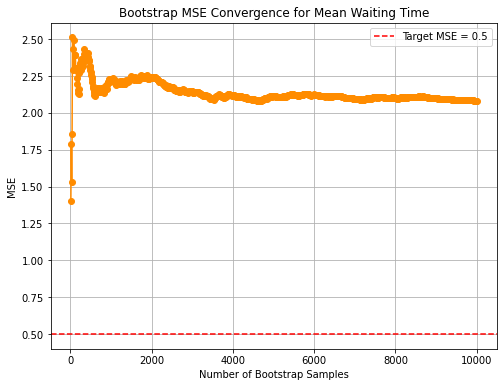

Run 1
Mean, Median, Max and Variance of Waiting Time: 106.16 s, 12.87 s, 437.54 s, 19232.00 s
Maximum Waiting Time 50th, 90th, 95th and 99th percentiles: [ 12.86580006 349.66094108 395.88976624 428.40978875]
MSE of Bootstrap Mean Waiting Time: 2.0636
95% CI for Mean Waiting Time (bootstrap): [103.06, 108.93]
Customers above 60.00 s: 3453, In percentage: 38.11%

Run 2
Mean, Median, Max and Variance of Waiting Time: 113.92 s, 13.41 s, 478.81 s, 21777.83 s
Maximum Waiting Time 50th, 90th, 95th and 99th percentiles: [ 13.40989038 372.60868553 421.70044294 462.9313314 ]
MSE of Bootstrap Mean Waiting Time: 2.2620
95% CI for Mean Waiting Time (bootstrap): [111.26, 116.79]
Customers above 60.00 s: 3617, In percentage: 39.76%

Run 3
Mean, Median, Max and Variance of Waiting Time: 95.13 s, 13.40 s, 401.14 s, 15518.01 s
Maximum Waiting Time 50th, 90th, 95th and 99th percentiles: [ 13.39896559 316.81627988 360.88293868 389.62553909]
MSE of Bootstrap Mean Waiting Time: 1.4862
95% CI for Mean Waitin

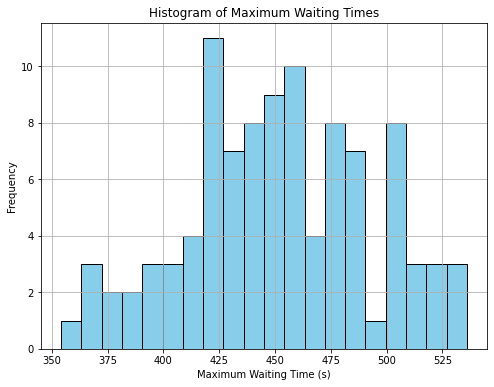

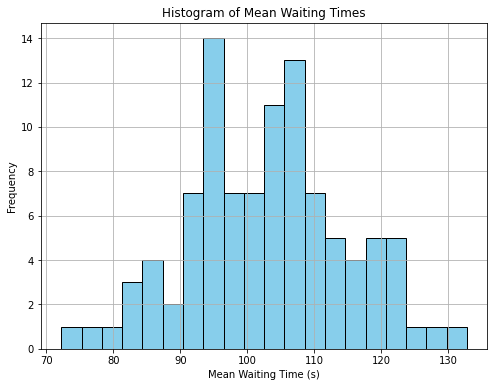

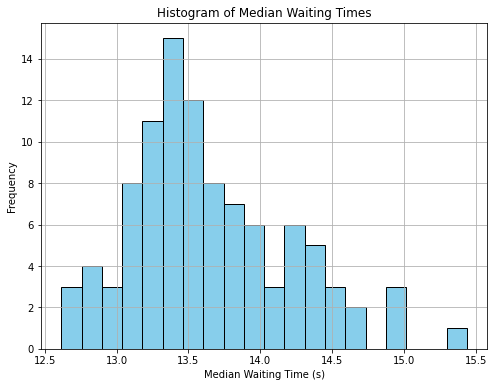

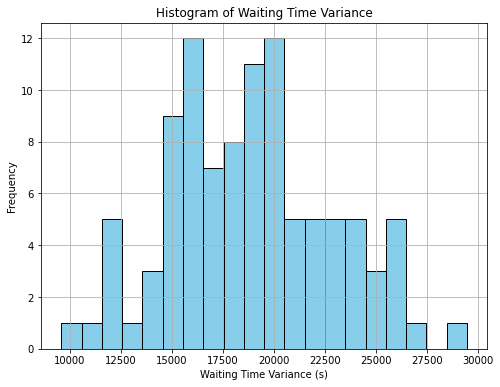

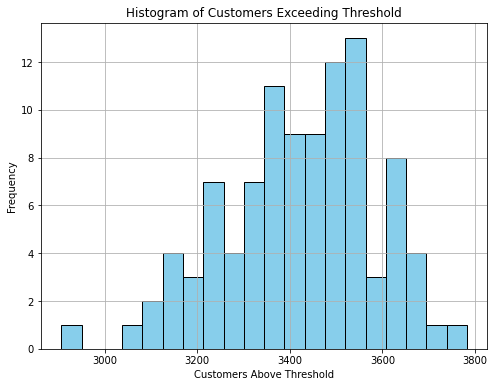

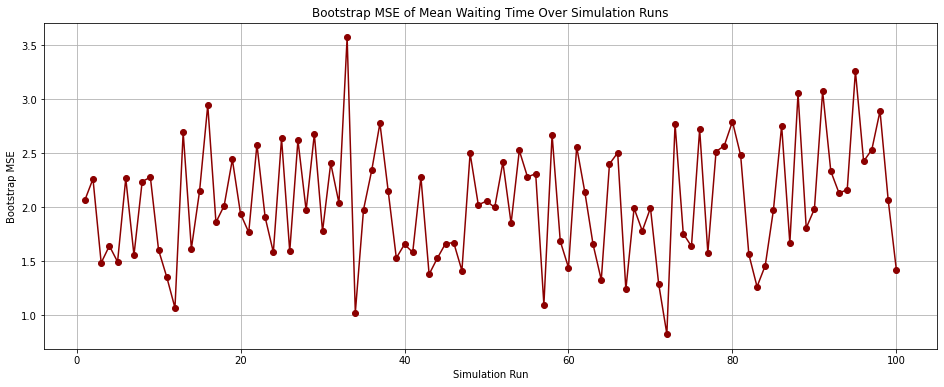

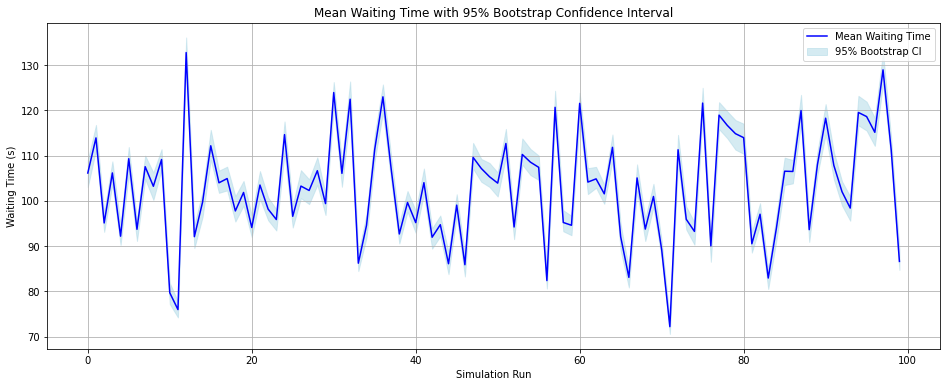

Elapsed time: 35.33 seconds


In [4]:
def main():
    # Parameters
    num_runs = 100  # Number of simulation runs
    threshold = 60  # Acceptable max waiting time threshold in seconds
    print_results = True

    # Initialize lists to store statistics
    max_waiting_times = []
    mean_waiting_times = []
    var_waiting_times = []
    median_waiting_times = []
    waiting_time_percentiles = []
    bootstrap_mse_over_runs = []
    bootstrap_mean_waiting_times = []
    ci_lows = []
    ci_highs = []
    threshold_violations = []

    # Initialize run time
    run_start_time = time()

    # Simulation class
    simulation = Simulation()

    bootstrap_mse_convergence(simulation, stat_func=np.mean, max_bootstrap=10000, step=10)

    for i in range(num_runs):
        if print_results:
            print(f"Run {i + 1}")

        # Run simulation
        requests = simulation.run()

        # Initialize statistics
        stats = Stats(requests)
        waiting_time = stats.get_waiting_time()

        # Calculate statistics
        max_waiting_time = np.max(waiting_time)
        mean_waiting_time = np.mean(waiting_time)
        var_waiting_time = np.var(waiting_time)
        median_waiting_time = np.median(waiting_time)
        waiting_time_percentile = np.percentile(waiting_time, [50, 90, 95, 99])

        max_waiting_times.append(max_waiting_time)
        mean_waiting_times.append(mean_waiting_time)
        var_waiting_times.append(var_waiting_time)
        median_waiting_times.append(median_waiting_time)
        waiting_time_percentiles.append(waiting_time_percentile)

        # Bootstrap for mean and MSE
        true_mean, mse, bootstrap_samples = stats.mse_bootstrap(np.mean, num_bootstrap=100)
        bootstrap_mse_over_runs.append(mse)
        bootstrap_mean_waiting_times.append(np.mean(bootstrap_samples))

        # Optional: Bootstrap CI for the mean
        ci_low, ci_high = np.percentile(bootstrap_samples, [2.5, 97.5])
        ci_lows.append(ci_low)
        ci_highs.append(ci_high)

        # Print basic statistics
        if print_results:
            print(f"Mean, Median, Max and Variance of Waiting Time: {mean_waiting_time:.2f} s, {median_waiting_time:.2f} s, {max_waiting_time:.2f} s, {var_waiting_time:.2f} s")
            print(f"Maximum Waiting Time 50th, 90th, 95th and 99th percentiles: {waiting_time_percentile}")
            print(f"MSE of Bootstrap Mean Waiting Time: {mse:.4f}")
            print(f"95% CI for Mean Waiting Time (bootstrap): [{ci_low:.2f}, {ci_high:.2f}]")

        # Customers above threshold
        count_above, pct_above = stats.num_customers_above_threshold(threshold)
        threshold_violations.append(count_above)
        if print_results:
            print(f"Customers above {threshold:.2f} s: {count_above}, In percentage: {pct_above:.2f}%\n")

    # Plotting
    def make_hist(data, title, xlabel):
        plt.figure(figsize=(8, 6))
        plt.hist(data, bins=20, color='skyblue', edgecolor='black')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    make_hist(max_waiting_times, 'Histogram of Maximum Waiting Times', 'Maximum Waiting Time (s)')
    make_hist(mean_waiting_times, 'Histogram of Mean Waiting Times', 'Mean Waiting Time (s)')
    make_hist(median_waiting_times, 'Histogram of Median Waiting Times', 'Median Waiting Time (s)')
    make_hist(var_waiting_times, 'Histogram of Waiting Time Variance', 'Waiting Time Variance (s)')
    make_hist(threshold_violations, 'Histogram of Customers Exceeding Threshold', 'Customers Above Threshold')

    # Plot MSE over runs
    plt.figure(figsize=(16, 6))
    plt.plot(range(1, num_runs + 1), bootstrap_mse_over_runs, marker='o', color='darkred')
    plt.title('Bootstrap MSE of Mean Waiting Time Over Simulation Runs')
    plt.xlabel('Simulation Run')
    plt.ylabel('Bootstrap MSE')
    plt.grid(True)
    plt.show()

    # Optional: CI band for mean waiting time
    plt.figure(figsize=(16, 6))
    plt.plot(mean_waiting_times, label="Mean Waiting Time", color='blue')
    plt.fill_between(range(num_runs), ci_lows, ci_highs, color='lightblue', alpha=0.5, label="95% Bootstrap CI")
    plt.title('Mean Waiting Time with 95% Bootstrap Confidence Interval')
    plt.xlabel('Simulation Run')
    plt.ylabel('Waiting Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

    run_end_time = time()
    print(f"Elapsed time: {run_end_time - run_start_time:.2f} seconds")


if __name__ == "__main__":
    main()

Running single simulation for bootstrap convergence analysis...


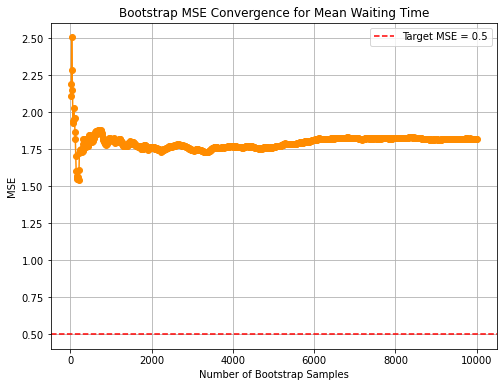

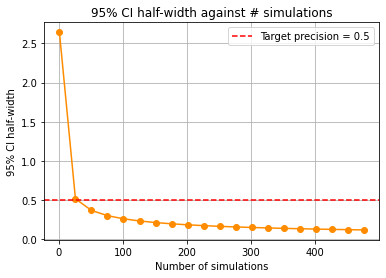

In [10]:
simulation = Simulation()
bootstrap_mse_convergence(simulation, stat_func=np.mean, max_bootstrap=10000, step=10)